In [11]:
import numpy as np
try:
    import itertools.izip as zip
except ImportError:
    import itertools
    
from pathlib import Path


### Parameters

In [12]:
pop_size = 1000
alphabet = ['0', '1']
seq_length = 1

base_haplotype = "0"
fraction_base = 0.5

fitness_nodrug = {'base': 1, 'resistant': 0.9, 'fusion': 0.95}
fitness_drug = {'base': 0.8, 'resistant': 0.9, 'fusion': 0.85}

fitness_base = fitness_nodrug['base']
fitness_resistant = fitness_nodrug['resistant']
fitness_fusion = fitness_nodrug['fusion']

fitness_effect = 1 # fitness effect if a functional mutation occurs
fitness_chance = 0.01 # chance that a mutation has a fitness effect

mutation_rate = 0.005
fusion_rate = 0.01

drug_interval = 150


### Population

In [13]:
pop = {}
pop["0"] = pop_size * fraction_base
pop["1"] = pop_size * (1 - fraction_base)

print("Starting population: {}".format(pop))

fitness = {}
fitness["0"] = fitness_base
fitness["1"] = fitness_resistant

print("Fitness: {}".format(fitness))

def get_random_haplotype():
    """Returns a random haplotype from the population, weighted by the frequency of the haplotype"""
    haplotypes = list(pop.keys()) 
    frequencies = [x/float(pop_size) for x in pop.values()]
    total = sum(frequencies)
    frequencies = [x / total for x in frequencies]
    return np.random.choice(haplotypes, p=frequencies)

def update_fitness(haplotype):
    old_fitness = fitness[haplotype]
    if (np.random.random() < fitness_chance):
        return old_fitness * fitness_effect
    else:
        return old_fitness


Starting population: {'0': 500.0, '1': 500.0}
Fitness: {'0': 1, '1': 0.9}


### Mutation

In [14]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)

def make_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype    

def get_mutant_fitness(haplotype):
    old_fitness = fitness[haplotype]
    if (np.random.random() < fitness_chance):
        return old_fitness * fitness_effect
    else:
        return old_fitness

def mutation_event():
    haplotype = get_random_haplotype()

    # Don't let fused cells mutate.
    if len(haplotype) >= 2:
        return
    
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = make_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
        if new_haplotype not in fitness:
            fitness[new_haplotype] = get_mutant_fitness(haplotype)

def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()

### Fusion

In [15]:
def get_fusion_count():
    mean = fusion_rate * pop_size
    return np.random.poisson(mean)

def make_fusion(hap1, hap2):
    fused = hap1 + hap2
    return ''.join(sorted(fused))

def get_fusion_fitness(haplotype):
    from math import e
    
    length = len(haplotype)

    # Don't let the haplotype go past 2 chars.
    if length > 2:
        return 0

    # Use a Gaussian function such that the fitness is lower when very short and very long.
    # f(x) = ae^(-(x-b)^2/2c^2)
    a = fitness_fusion
    b = 2 # max fitness at length 2
    c = 1 # stdev
    
    fitness = a * e ** (-1 * ((length - b) ** 2) / ((2 * c) ** 2))
    return fitness

def fusion_event():
    hap1 = get_random_haplotype()
    hap2 = get_random_haplotype()

    # Don't let the same haplotypes fuse.
    if hap1 == hap2:
        return
        
    # If fusion would remove either population of cells, don't let it happen.
    if pop[hap1] == 1 or pop[hap2] == 1:
        return

    pop[hap1] -= 1
    pop[hap2] -= 1

    new_haplotype = make_fusion(hap1, hap2)

    if new_haplotype in pop:
        pop[new_haplotype] += 1
    else:
        pop[new_haplotype] = 1
    if new_haplotype not in fitness:
        fitness[new_haplotype] = get_fusion_fitness(new_haplotype)

def fusion_step():
    fusion_count = get_fusion_count()
    for i in range(fusion_count):
        fusion_event()

### Offspring

In [16]:
def get_offspring_counts():
    haplotypes = list(pop.keys())
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    weights = [x / total for x in weights]
    return list(np.random.multinomial(pop_size, weights))

def offspring_step():
    haplotypes = list(pop.keys())
    counts = get_offspring_counts()
    for (haplotype, count) in zip(haplotypes, counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            del pop[haplotype]

### Analysis

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

def get_frequency(haplotype, generation):
    pop_at_generation = history[generation]
    if haplotype in pop_at_generation:
        return pop_at_generation[haplotype]/float(pop_size)
    else:
        return 0
    
def get_trajectory(haplotype):
    trajectory = [get_frequency(haplotype, gen) for gen in range(generations)]
    return trajectory

def get_all_haplotypes():
    haplotypes = set()   
    for generation in history:
        for haplotype in generation:
            haplotypes.add(haplotype)
    return haplotypes

colors = ["#781C86", "#571EA2", "#462EB9", "#3F47C9", "#3F63CF", "#447CCD", "#4C90C0", "#56A0AE", "#63AC9A", "#72B485", "#83BA70", "#96BD60", "#AABD52", "#BDBB48", "#CEB541", "#DCAB3C", "#E49938", "#E68133", "#E4632E", "#DF4327", "#DB2122"]
colors_lighter = ["#A567AF", "#7F85DB", "#88B5D5", "#8FC0C9", "#97C8BC", "#A1CDAD", "#ACD1A0", "#B9D395", "#C6D38C", "#D3D285", "#DECE81", "#E8C77D", "#EDBB7A", "#EEAB77", "#ED9773", "#EA816F", "#E76B6B"]

def stacked_trajectory_plot(xlabel="generation"):
    mpl.rcParams['font.size']=18
    haplotypes = get_all_haplotypes()
    names = {
        '0': 'sensitive', 
        '1': 'resistant', 
        '01': 'fusion'
    }
    hap_labels = [names[hap] for hap in haplotypes]
    trajectories = [get_trajectory(haplotype) for haplotype in haplotypes]
    plt.stackplot(range(generations), trajectories, colors=colors_lighter, labels=hap_labels)
    for x in range(0, 1000, drug_interval):
        plt.axvline(x, color='orange')
    plt.legend(bbox_to_anchor=(1.25, 1))
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel(xlabel)


### Drug

In [18]:
def set_drug(is_present):
    # TODO: Maybe don't use globals here? We can pass the drug state into the step functions.
    global fitness_base
    global fitness_resistant
    global fitness_fusion

    if is_present:
        fitness_base = fitness_drug['base']
        fitness_resistant = fitness_drug['resistant']
        fitness_fusion = fitness_drug['fusion']
    else:
        fitness_base = fitness_nodrug['base']
        fitness_resistant = fitness_nodrug['resistant']
        fitness_fusion = fitness_nodrug['fusion']

    fitness["0"] = fitness_base
    fitness["1"] = fitness_resistant
    haplotypes = list(pop.keys())
    for hap in haplotypes:
        if len(hap) < 2: continue
        fitness[hap] = get_fusion_fitness(hap)


# Define functions for all the regimens for convenience

drug_state = False

def drug_off(generation):
    set_drug(False)

def drug_on(generation):
    set_drug(True)

def drug_on_off(generation):
    if generation == 0:
        set_drug(True)
    elif generation == 250:
        set_drug(False)


def drug_off_on(generation):
    if generation == 0:
        set_drug(False)
    elif generation == 250:
        set_drug(True)

def drug_off_on_off_on(generation):
    global drug_state
    if generation == 0:
        drug_state = False
    elif generation % drug_interval == 0:
        drug_state = not drug_state
        set_drug(drug_state)
    set_drug(drug_state)

regimens = {
    0: drug_off,
    1: drug_on,
    2: drug_off_on,
    3: drug_on_off,
    4: drug_off_on_off_on
}

# Make it easy to save the regimen name as part of the output file.
# TODO: Maybe just make these the keys for the regimen dict?
regimen_names = {
    0: 'drug_off',
    1: 'drug_on',
    2: 'drug_off_on',
    3: 'drug_on_off',
    4: 'drug_off_on_off_on'
}

def drug_step(generation, regimen_num):
    regimens[regimen_num](generation)



### Simulation

In [ ]:
import csv
from pathlib import Path

generations = 1000
trials = 20
history = []

def time_step():
    mutation_step()
    fusion_step()
    offspring_step()

def simulate(regimen):
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        drug_step(i, regimen)
        time_step()
        clone_pop = dict(pop)
        history.append(clone_pop)

# All the starting fractions we wish to test.
fractions = [0.1,0.25,0.5,0.75,0.9]

# All the drug regimens we wish to test. For IDs, see the cell above.
test_regimens = [4]

# All the drug intervals we wish to test
drug_intervals = [25,50,75,90]

for drug_interval in drug_intervals:
    regimen_num = 4
    for fraction in fractions:
        fraction_base = fraction

        final_pops = []
        fused_01_outcomes = []
        fused_11_outcomes = []
        for i in range(trials):
            
            # Initialize population 
            pop = {}
            pop["0"] = pop_size * fraction_base
            pop["1"] = pop_size * (1 - fraction_base)
            
            simulate(regimen_num)
            
            print('Final population: {}'.format(pop))
            final_pops.append([val for pair in zip(pop.keys(), pop.values()) for val in pair])
            
            fused_01 = 0
            fused_11 = 0
            for (hap, count) in pop.items():
                if hap == "01":
                    fused_01 += count
            fused_01_proportion = fused_01 / float(pop_size)
            fused_01_outcomes.append(fused_01_proportion)

        # Calculate average proportion over all trials
        avg_01_proportion = 0.0
        for proportion in fused_01_outcomes:
            avg_01_proportion += proportion
        avg_01_proportion = avg_01_proportion / len(fused_01_outcomes)
        print('Mean 01 proportion after {} trials: {}'.format(trials, avg_01_proportion))

        filename = "r{}_output_{}_{}.csv".format(regimen_num, fraction_base, drug_interval)
        filepath = Path('./output') / filename
        with filepath.open('w') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([fraction_base])
            csvwriter.writerow([avg_01_proportion])
            csvwriter.writerow([drug_interval])
            csvwriter.writerow([regimen_names[regimen_num]])
            csvwriter.writerows(final_pops)

plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
stacked_trajectory_plot()


Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'0': 14, '1': 10, '01': 976}
Final population: {'01': 1000}
Final population: {'0': 111, '1': 647, '01': 242}
Final population: {'0': 12, '1': 394, '01': 594}
Final population: {'01': 1000}
Final population: {'0': 13, '1': 238, '01': 749}
Final population: {'01': 1000}
Mean 01 proportion after 20 trials: 0.9280499999999998
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final population: {'01': 1000}
Final

### Plotting


Plotting  100
Plotting  25
Plotting  50
Plotting  75
Plotting  100
Plotting  25
Plotting  50
Plotting  75
Plotting  100
Plotting  25
Plotting  50
Plotting  75
Plotting  100
Plotting  25
Plotting  50
Plotting  75
Plotting  100
Plotting  25
Plotting  50
Plotting  75


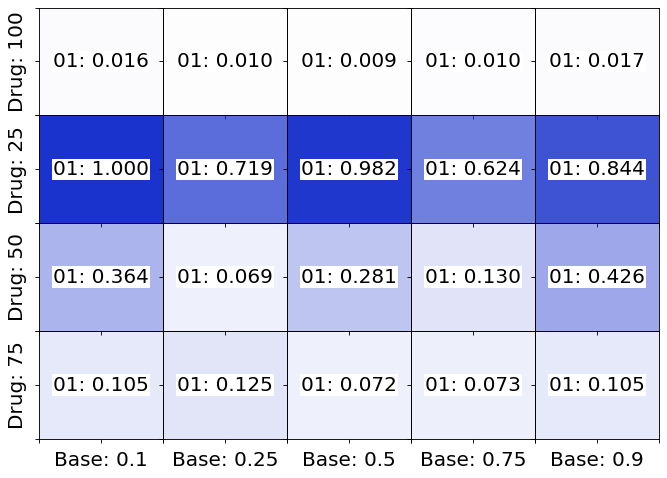

In [84]:
# Uncomment and run this cell if you'd like to create a table showing the final proportions of
# fused cells for each regimen and starting sensitive concentration.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.figure(figsize=(10, 7), dpi=80)
gs = gridspec.GridSpec(4, 5)
gs.update(wspace=0, hspace=0) # set the spacing between axes. 


results = [file for file in Path('./output').iterdir() if file.is_file() and file.name.startswith('r')]
results.sort()
for count, file in enumerate(results):
    row_num = count % 4
    col_num = int(count / 4)

    with file.open('r') as csvfile:
        reader = csv.reader(csvfile)
        rows = [row for row in reader]
        #print(rows[0])
        starting_fraction = float(rows[0][0])
        proportions = [float(val) for val in rows[1]]
        proportion_fused = sum(proportions)
        #print(proportion_fused)

        drug_interval = rows[2][0]
        print('Plotting ', drug_interval)

        ax = plt.subplot(gs[row_num, col_num])
        ax.set_facecolor((0.1, 0.2, 0.8, proportion_fused)) #/ 0.02))
        ax.text(0.5, 0.5, '01: {:.3f}'.format(proportions[0]),
           bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
           ha='center', va='center')

      # Add the drug regimen to the bottom row label.
        if row_num == 3 or col_num == 0:
            if row_num == 3:
                ax.set_xlabel('Base: {}'.format(starting_fraction))
                ax.xaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([])

                #ax.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False)
            if col_num == 0:
                # Add the proportion to the first column label
                ax.set_ylabel('Drug: {}'.format(drug_interval))
                ax.yaxis.set_ticklabels([])
                ax.xaxis.set_ticklabels([])
                #ax.tick_params(axis='both', which='both', bottom=False, left=False)
        else:
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticklabels([])
                #ax.tick_params(axis='x', which='major', bottom=False, labelbottom=False, left=False, labelleft=False)
    
    row_num += 1
    col_num += 1



In [81]:
for count, file in enumerate(results):
    row_num = count % 4
    col_num = int(count / 4)
    print(row_num, col_num, file)

0 0 output/r4_output_0.1_100.csv
1 0 output/r4_output_0.1_25.csv
2 0 output/r4_output_0.1_50.csv
3 0 output/r4_output_0.1_75.csv
0 1 output/r4_output_0.25_100.csv
1 1 output/r4_output_0.25_25.csv
2 1 output/r4_output_0.25_50.csv
3 1 output/r4_output_0.25_75.csv
0 2 output/r4_output_0.5_100.csv
1 2 output/r4_output_0.5_25.csv
2 2 output/r4_output_0.5_50.csv
3 2 output/r4_output_0.5_75.csv
0 3 output/r4_output_0.75_100.csv
1 3 output/r4_output_0.75_25.csv
2 3 output/r4_output_0.75_50.csv
3 3 output/r4_output_0.75_75.csv
0 4 output/r4_output_0.9_100.csv
1 4 output/r4_output_0.9_25.csv
2 4 output/r4_output_0.9_50.csv
3 4 output/r4_output_0.9_75.csv


In [24]:
results

[PosixPath('output/r4_output_0.1_100.csv'),
 PosixPath('output/r4_output_0.1_150.csv'),
 PosixPath('output/r4_output_0.1_200.csv'),
 PosixPath('output/r4_output_0.1_50.csv'),
 PosixPath('output/r4_output_0.3_100.csv'),
 PosixPath('output/r4_output_0.3_150.csv'),
 PosixPath('output/r4_output_0.3_200.csv'),
 PosixPath('output/r4_output_0.3_50.csv'),
 PosixPath('output/r4_output_0.4_100.csv'),
 PosixPath('output/r4_output_0.4_150.csv'),
 PosixPath('output/r4_output_0.4_50.csv'),
 PosixPath('output/r4_output_0.5_100.csv'),
 PosixPath('output/r4_output_0.5_150.csv'),
 PosixPath('output/r4_output_0.5_200.csv'),
 PosixPath('output/r4_output_0.5_50.csv'),
 PosixPath('output/r4_output_0.6_100.csv'),
 PosixPath('output/r4_output_0.6_150.csv'),
 PosixPath('output/r4_output_0.6_50.csv'),
 PosixPath('output/r4_output_0.7_100.csv'),
 PosixPath('output/r4_output_0.7_150.csv'),
 PosixPath('output/r4_output_0.7_200.csv'),
 PosixPath('output/r4_output_0.7_50.csv'),
 PosixPath('output/r4_output_0.9_100.c